### Carbon Intensity API

https://api.carbonintensity.org.uk/intensity

Carbon intensity now, indicated by traffic light system very low, low, moderate, high, very high.

Example response:

In [ ]:
{ 
  "data":[{ 
    "from": "2025-11-17T10:30Z",
    "to": "2025-11-17T11:00Z",
    "intensity": {
      "forecast": 122,
      "actual": 118,
      "index": "moderate"
    }
  }]
}

https://api.carbonintensity.org.uk/intensity/{from}/{to}

Example response:

In [ ]:
{
  "data": [
    {
      "from": "2024-11-16T00:00Z",
      "to": "2024-11-16T00:30Z",
      "intensity": {
        "forecast": 245,
        "actual": 242,
        "index": "high"
      }
    },
    {
      "from": "2024-11-16T00:30Z",
      "to": "2024-11-16T01:00Z",
      "intensity": {
        "forecast": 238,
        "actual": 235,
        "index": "high"
      }
    },
    # ... continues for every 30-min period in your range
  ]
}

In [ ]:
CARBON_INTENSITY
├── timestamp_from (PK)
├── timestamp_to
├── intensity_forecast (always present)
├── intensity_actual (nullable for future/recent data)
├── intensity_index ("very low", "low", etc.)
├── is_forecast (boolean: true if actual is null)
└── fetched_at (when you pulled this data)

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nbformat

yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%dT%H:%MZ")
now = datetime.now().strftime("%Y-%m-%dT%H:%MZ")

url = f"https://api.carbonintensity.org.uk/intensity/{yesterday}/{now}"
response = requests.get(url)
data = response.json()

# Convert to DataFrame for easy viewing
df = pd.json_normalize(data['data'])
df['from'] = pd.to_datetime(df['from'])
df['to'] = pd.to_datetime(df['to'])

### Visualisations

Fetching data from: https://api.carbonintensity.org.uk/intensity/2025-11-16T14:45Z/2025-11-17T14:45Z

Data fetched: 48 records
Time range: 2025-11-16 14:30:00+00:00 to 2025-11-17 14:30:00+00:00

First few rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   from                48 non-null     datetime64[ns, UTC]
 1   to                  48 non-null     datetime64[ns, UTC]
 2   intensity.forecast  48 non-null     int64              
 3   intensity.actual    48 non-null     int64              
 4   intensity.index     48 non-null     object             
dtypes: datetime64[ns, UTC](2), int64(2), object(1)
memory usage: 2.0+ KB
None


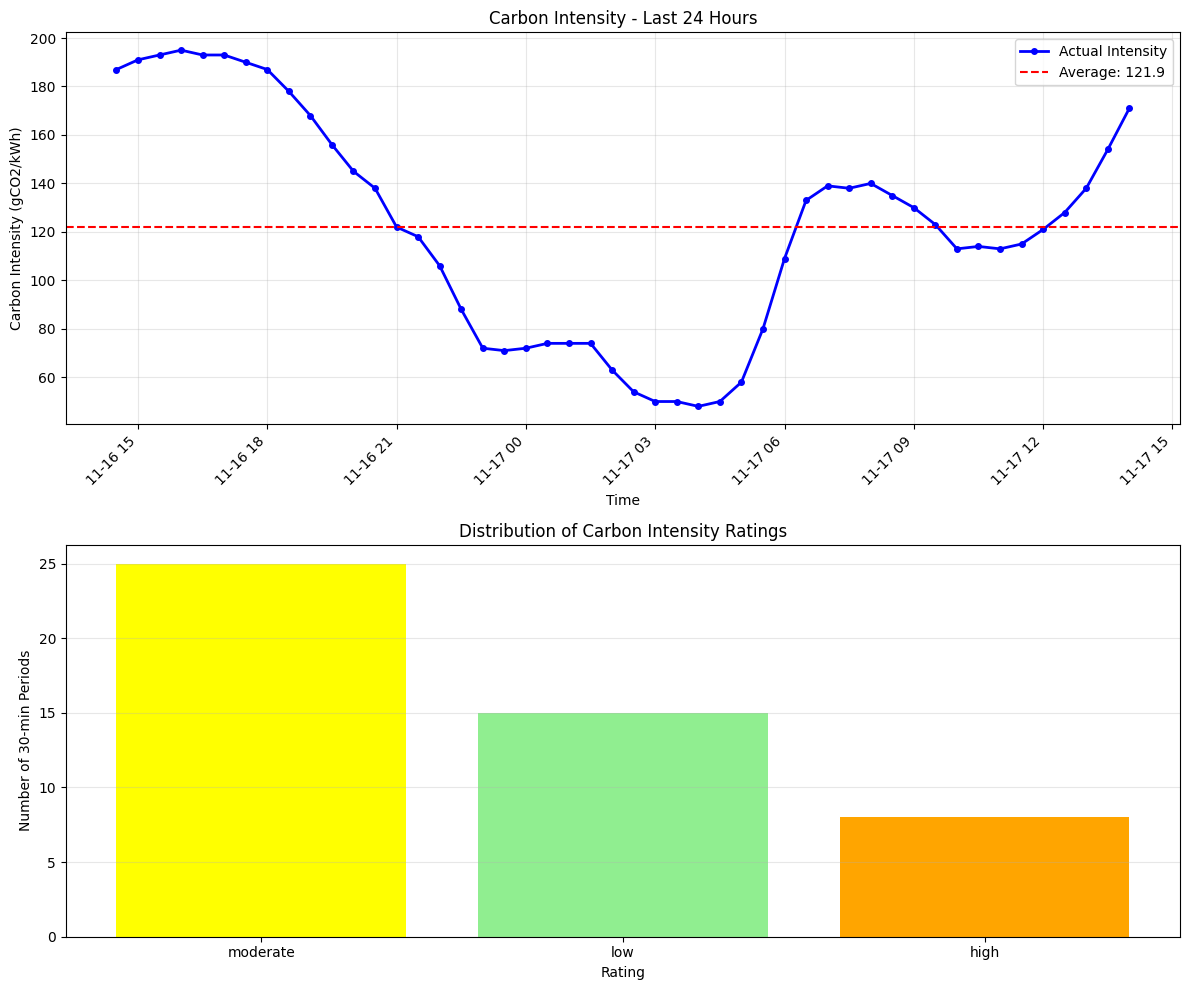

In [8]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Fetch data for last 24 hours
yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%dT%H:%MZ")
now = datetime.now().strftime("%Y-%m-%dT%H:%MZ")

url = f"https://api.carbonintensity.org.uk/intensity/{yesterday}/{now}"
print(f"Fetching data from: {url}")

response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.json_normalize(data['data'])
df['from'] = pd.to_datetime(df['from'])
df['to'] = pd.to_datetime(df['to'])

print(f"\nData fetched: {len(df)} records")
print(f"Time range: {df['from'].min()} to {df['to'].max()}")
print(f"\nFirst few rows:")
print(df.info())

# Create visualization with matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Time series
ax1.plot(df['from'], df['intensity.actual'], 'b-o', linewidth=2, markersize=4, label='Actual Intensity')
avg_intensity = df['intensity.actual'].mean()
ax1.axhline(y=avg_intensity, color='r', linestyle='--', label=f'Average: {avg_intensity:.1f}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Carbon Intensity (gCO2/kWh)')
ax1.set_title('Carbon Intensity - Last 24 Hours')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Bottom plot: Rating counts bar chart
rating_counts = df['intensity.index'].value_counts()
colors_map = {
    'very low': 'green',
    'low': 'lightgreen',
    'moderate': 'yellow',
    'high': 'orange',
    'very high': 'red'
}
bar_colors = [colors_map.get(x, 'gray') for x in rating_counts.index]

ax2.bar(rating_counts.index, rating_counts.values, color=bar_colors)
ax2.set_xlabel('Rating')
ax2.set_ylabel('Number of 30-min Periods')
ax2.set_title('Distribution of Carbon Intensity Ratings')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()